In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
import time
import os
import json
from sklearn.feature_selection import VarianceThreshold

In [2]:
if not os.path.exists("RandomForest/data"):
    os.makedirs("RandomForest/data")
if not os.path.exists("RandomForest/graph"):
    os.makedirs("RandomForest/graph")

In [3]:
# Cargar y ordenar las tablas por orden alfabetico para comaprar correctamente las predicciones
Xpd = pd.read_csv("data/bloodexpression.csv", index_col=0).sort_index(axis=0)
Ypd = pd.read_csv("data/thyrhipathia.csv", index_col=0).sort_index(axis=0)

In [4]:
# Guardar nombres antes de convertir
genes = Xpd.columns.tolist()  
vias_inicial = Ypd.columns.tolist()     
samples = Xpd.index.tolist()    
# Convertir a NumPy arrays
X = Xpd.values  
Y = Ypd.values  

In [5]:
variance_selector = VarianceThreshold(threshold=0)
X_clean = variance_selector.fit_transform(Xpd)
Y_clean = variance_selector.fit_transform(Y)

# Obtención de vías que quedaron después del filtro
vias = [via for via, mantener in zip(vias_inicial, variance_selector.get_support()) if mantener]

print(f"X: {X.shape[1]} → {X_clean.shape[1]} features")
print(f"Y: {Y.shape[1]} → {Y_clean.shape[1]} outputs")

cv_exter = KFold(n_splits=5, shuffle=True, random_state=42)

X: 3286 → 3286 features
Y: 1876 → 1873 outputs


In [6]:
R2_metricas = pd.DataFrame()
MAE_metricas = pd.DataFrame()
RMSE_metricas = pd.DataFrame()
importancias_todos_folds = []

for fold, (train_id, test_id) in enumerate(cv_exter.split(X_clean), start=1):
    
    fold_start = time.perf_counter()
    print(f"FOLD EXTERNO {fold}/5")
    
    # Dividir datos
    X_train, X_test = X_clean[train_id], X_clean[test_id]
    Y_train, Y_test = Y_clean[train_id], Y_clean[test_id]
    
    print(f"Datos:")
    print(f"   Train: X={X_train.shape}, Y={Y_train.shape}")
    print(f"   Test:  X={X_test.shape}, Y={Y_test.shape}")
    
    # ENTRENAR RANDOM FOREST (MULTITAREA)
    
    print(f"\nInicio RandomForest")
    
    modelo = RandomForestRegressor(
        n_estimators=200,
        max_depth= 10,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features= 1.0,
        n_jobs=-1,
        random_state=42,
        bootstrap=True,
        oob_score=False,
        verbose=0
    )
    
    modelo.fit(X_train, Y_train)
    
    print(f"Entrenamiento completado")

    Y_pred = modelo.predict(X_test)
    
    print(f"\n Distribuciones:")
    print(f"   Y_test: mean={Y_test.mean():.3f}, std={Y_test.std():.3f}")
    print(f"   Y_pred: mean={Y_pred.mean():.3f}, std={Y_pred.std():.3f}")
    
    # MÉTRICAS POR VÍA

    print(f"\nMétricas por vía:")
    
    print(f"\tEvaluación test/predicción:")
    # Listas temporales por fold
    r2_fold = []
    mae_fold = []
    rmse_fold = []
    
    count = 0
    for via_idx, via in enumerate(vias):
        y_test = Y_test[:, via_idx]
        y_pred = Y_pred[:, via_idx]
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        if r2 < -0.1:
            print(f"\t\tR² muy negativo via_{via}: {r2:.4f}")
            count += 1
        
        # Agregar a listas
        r2_fold.append(r2)
        mae_fold.append(mae)
        rmse_fold.append(rmse)
    
    # Agregar como columna al DataFrame
    R2_metricas[f'fold_{fold}'] = r2_fold
    MAE_metricas[f'fold_{fold}'] = mae_fold
    RMSE_metricas[f'fold_{fold}'] = rmse_fold
    
    print(f"\tVías con R² < -0.1: {count}/{len(vias)}")
    
    # Guardar importancias
    importancias_fold = []
    for estimator in modelo.estimators_:
        importancias_fold.append(estimator.feature_importances_)
    
    importancias_todos_folds.append({
        'fold': fold,
        'importancias': np.array(importancias_fold)
    })
    print(f"")
    
    fold_end = time.perf_counter()
    fold_time = fold_end - fold_start
    tiempo_restante = fold_time * (5 - fold)
    
    print(f"\nTiempo fold {fold}: {fold_time/60:.1f} min")
    print(f"Tiempo estimado restante: {tiempo_restante/60:.1f} min")


FOLD EXTERNO 1/5
Datos:
   Train: X=(417, 3286), Y=(417, 1873)
   Test:  X=(105, 3286), Y=(105, 1873)

Inicio RandomForest
Entrenamiento completado

 Distribuciones:
   Y_test: mean=0.048, std=0.087
   Y_pred: mean=0.048, std=0.087

Métricas por vía:
	Evaluación test/predicción:
		R² muy negativo via_P-hsa03320-66: -0.5278
		R² muy negativo via_P-hsa03460-48: -0.2207
		R² muy negativo via_P-hsa03460-28: -0.1002
		R² muy negativo via_P-hsa04015-17: -0.2857
		R² muy negativo via_P-hsa04015-30: -0.1736
		R² muy negativo via_P-hsa04015-14: -0.1411
		R² muy negativo via_P-hsa04015-67: -0.1738
		R² muy negativo via_P-hsa04022-65: -0.1129
		R² muy negativo via_P-hsa04022-66: -0.1001
		R² muy negativo via_P-hsa04024-44 67: -0.1475
		R² muy negativo via_P-hsa04024-101: -0.1234
		R² muy negativo via_P-hsa04062-25: -0.1478
		R² muy negativo via_P-hsa04062-33: -0.2393
		R² muy negativo via_P-hsa04062-35 36 37: -0.3202
		R² muy negativo via_P-hsa04062-38: -0.2158
		R² muy negativo via_P-hsa04064-4:

In [7]:
pathway_result = "RandomForest/data/Prueba100_deep10"
if not os.path.exists(pathway_result):
    os.makedirs(pathway_result)

In [8]:
# Agregar índice con nombres de vías
R2_metricas.index = [f'via_{via}' for via in vias]
MAE_metricas.index = [f'via_{via}' for via in vias]
RMSE_metricas.index = [f'via_{via}' for via in vias]

# Agregar estadísticas (promedio y std entre folds)
R2_metricas['mean'] = R2_metricas.mean(axis=1)
R2_metricas['std'] = R2_metricas.std(axis=1)

MAE_metricas['mean'] = MAE_metricas.mean(axis=1)
MAE_metricas['std'] = MAE_metricas.std(axis=1)

RMSE_metricas['mean'] = RMSE_metricas.mean(axis=1)
RMSE_metricas['std'] = RMSE_metricas.std(axis=1)

# Guardar
R2_metricas.to_csv(f'{pathway_result}/resultados_r2.csv')
MAE_metricas.to_csv(f'{pathway_result}/resultados_mae.csv')
RMSE_metricas.to_csv(f'{pathway_result}/resultados_rmse.csv')

# Mostrar resultados
print("\nR² por vía (filas) y fold (columnas):")
print(R2_metricas)

print("\n Top 10 vías con mejor R² promedio:")
print(R2_metricas.sort_values('mean', ascending=False).head(10))

print("\n Top 10 vías con peor R² promedio:")
print(R2_metricas.sort_values('mean', ascending=True).head(10))

print("\nVías con R² promedio positivos:")
print(len(R2_metricas[R2_metricas['mean'] > 0]))
print(R2_metricas[R2_metricas['mean'] > 0])


R² por vía (filas) y fold (columnas):
                      fold_1    fold_2    fold_3    fold_4    fold_5  \
via_P-hsa03320-37   0.003377  0.041944  0.015361  0.054966 -0.114297   
via_P-hsa03320-61   0.209759  0.011759  0.050731  0.153254  0.141918   
via_P-hsa03320-46  -0.008108  0.004911 -0.118648 -0.033261 -0.148345   
via_P-hsa03320-57  -0.077773 -0.005493 -0.061014 -0.050238 -0.121898   
via_P-hsa03320-64  -0.025849 -0.025667  0.028219  0.039744  0.006760   
...                      ...       ...       ...       ...       ...   
via_P-hsa05321-74  -0.125321  0.171760  0.084432  0.079135  0.151631   
via_P-hsa05321-81  -0.049881  0.022748  0.092428 -0.023874 -0.059927   
via_P-hsa05321-138  0.313026  0.264560  0.448460  0.317101  0.329562   
via_P-hsa05321-75  -0.332758 -0.007437  0.006125 -0.145555 -0.063959   
via_P-hsa05321-152  0.045300  0.065151  0.009457 -0.126137 -0.009063   

                        mean       std  
via_P-hsa03320-37   0.000270  0.060152  
via_P-hsa03320

In [9]:
# Estadísticas por fold
print("\nEstadísticas por fold:")
print(R2_metricas.drop(['mean', 'std'], axis=1).describe())


Estadísticas por fold:
            fold_1       fold_2       fold_3       fold_4       fold_5
count  1873.000000  1873.000000  1873.000000  1873.000000  1873.000000
mean      0.021624     0.095476     0.055619     0.064331     0.058709
std       2.432291     0.147458     0.511200     0.288126     1.058627
min    -104.348219    -1.682095   -14.943807    -9.506469   -45.348872
25%       0.009141     0.007718    -0.007522     0.000237     0.003138
50%       0.077341     0.065520     0.059952     0.069657     0.056887
75%       0.170139     0.162098     0.143237     0.146057     0.141349
max       0.650208     0.634067     0.613836     0.630307     0.729747


In [10]:
# Filtrar vías con todos los R² positivos
# Excluir las columnas 'mean' y 'std' si las tienes
columnas_folds = [col for col in R2_metricas.columns if col.startswith('fold_')]

# Opción 1: Filtrar vías donde TODOS los folds son positivos
vias_positivas = R2_metricas[(R2_metricas[columnas_folds] > 0).all(axis=1)]

print(f"Vías originales: {len(R2_metricas)}")
print(f"Vías con R² positivo en todos los folds: {len(vias_positivas)}")
print(f"Vías eliminadas: {len(R2_metricas) - len(vias_positivas)}")

print("\nVías con R² positivo:")
print(vias_positivas)


Vías originales: 1873
Vías con R² positivo en todos los folds: 947
Vías eliminadas: 926

Vías con R² positivo:
                      fold_1    fold_2    fold_3    fold_4    fold_5  \
via_P-hsa03320-61   0.209759  0.011759  0.050731  0.153254  0.141918   
via_P-hsa03320-65   0.426797  0.437589  0.323830  0.331861  0.306557   
via_P-hsa03320-58   0.047348  0.026623  0.052207  0.057383  0.020479   
via_P-hsa03320-59   0.042127  0.019478  0.053708  0.138926  0.078112   
via_P-hsa03320-63   0.006633  0.107807  0.061596  0.103795  0.061816   
...                      ...       ...       ...       ...       ...   
via_P-hsa05231-17   0.272526  0.249189  0.162252  0.174269  0.111213   
via_P-hsa05321-95   0.204872  0.200252  0.127509  0.108681  0.172600   
via_P-hsa05321-122  0.156407  0.274532  0.190946  0.142966  0.173392   
via_P-hsa05321-55   0.170013  0.322913  0.188375  0.134603  0.211366   
via_P-hsa05321-138  0.313026  0.264560  0.448460  0.317101  0.329562   

                        

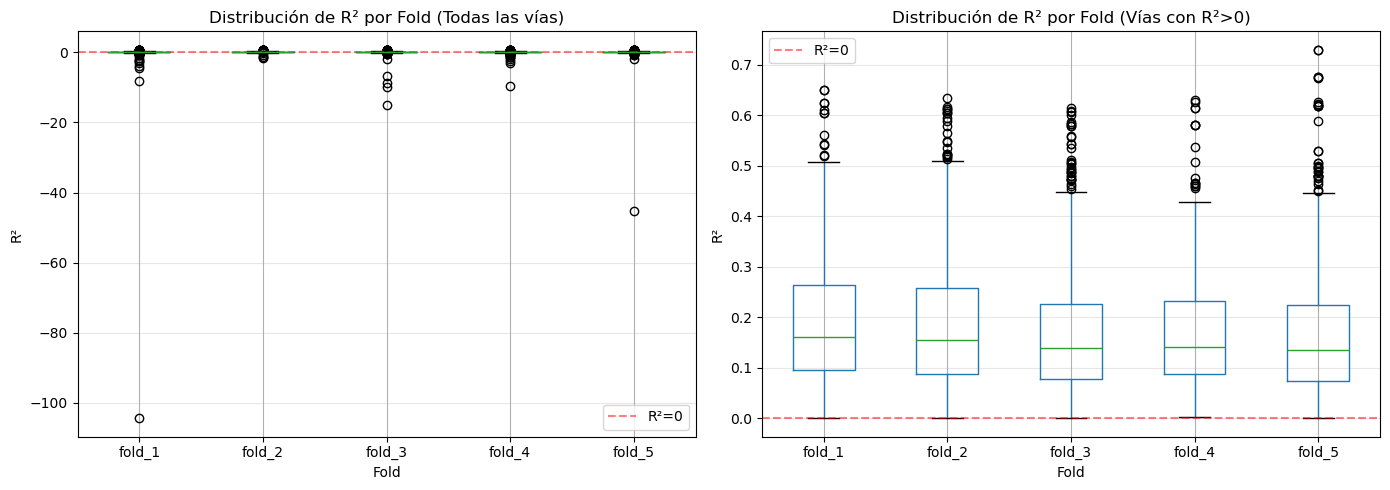

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot 1: R² original (todas las vías)
R2_metricas.drop(['mean', 'std'], axis=1).boxplot(ax=axes[0])
axes[0].set_ylabel('R²')
axes[0].set_xlabel('Fold')
axes[0].set_title('Distribución de R² por Fold (Todas las vías)')
axes[0].grid(axis='y', alpha=0.3)
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5, label='R²=0')
axes[0].legend()

# Boxplot 2: R² filtrado (solo vías positivas)
vias_positivas.drop(['mean', 'std'], axis=1).boxplot(ax=axes[1])
axes[1].set_ylabel('R²')
axes[1].set_xlabel('Fold')
axes[1].set_title('Distribución de R² por Fold (Vías con R²>0)')
axes[1].grid(axis='y', alpha=0.3)
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5, label='R²=0')
axes[1].legend()

plt.tight_layout()
plt.savefig(f'{pathway_result}/boxplot_r2_folds.png', dpi=300)
plt.show()

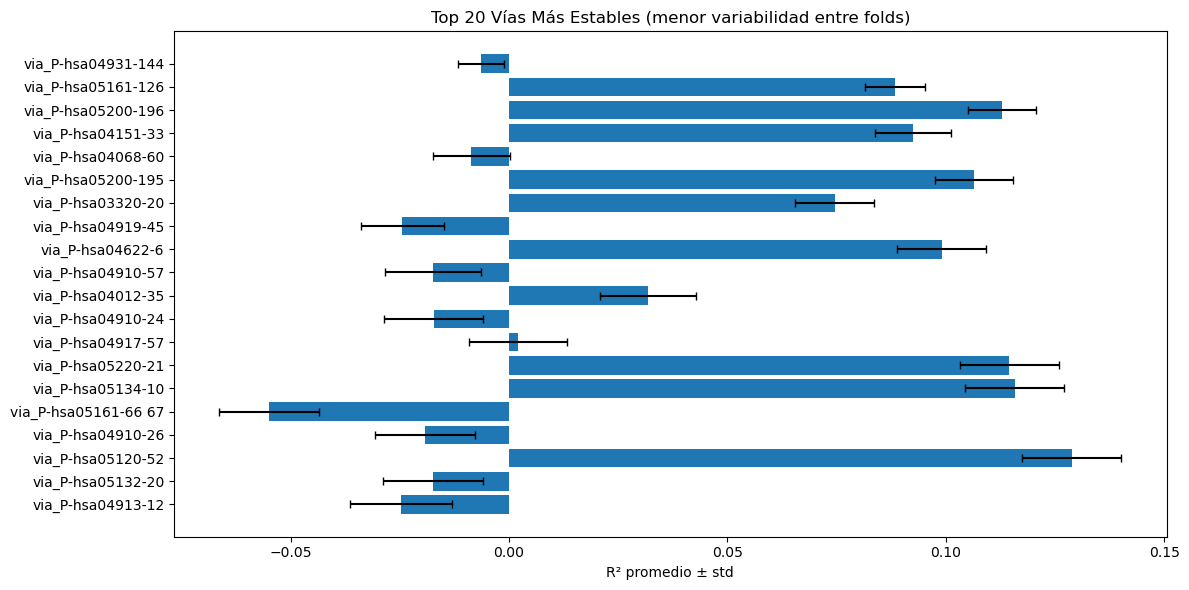

In [12]:
# Top vías más estables (menor std)
plt.figure(figsize=(12, 6))
top_estables = R2_metricas.nsmallest(20, 'std')
plt.barh(range(len(top_estables)), top_estables['mean'], 
         xerr=top_estables['std'], capsize=3)
plt.yticks(range(len(top_estables)), top_estables.index)
plt.xlabel('R² promedio ± std')
plt.title('Top 20 Vías Más Estables (menor variabilidad entre folds)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f'{pathway_result}/vias_estables_R.png', dpi=300)
plt.show()


Comparación antes/después del filtro:

ANTES:
count    1873.000000
mean        0.059152
std         0.592528
min       -21.180502
25%         0.003667
50%         0.062419
75%         0.141806
max         0.650639
Name: mean, dtype: float64

DESPUÉS:
count    947.000000
mean       0.171843
std        0.107963
min        0.021367
25%        0.094446
50%        0.140105
75%        0.229396
max        0.650639
Name: mean, dtype: float64


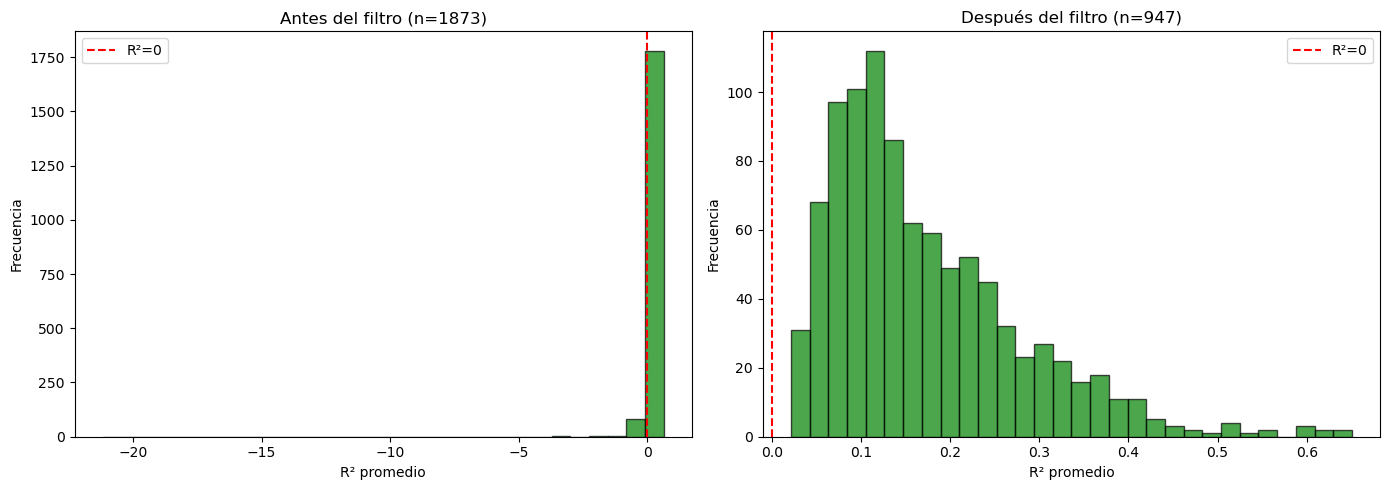

In [13]:
# Comparar estadísticas antes y después del filtro
print("\nComparación antes/después del filtro:")
print("\nANTES:")
print(R2_metricas['mean'].describe())

print("\nDESPUÉS:")
print(vias_positivas['mean'].describe())

# Visualizar la diferencia
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Antes
axes[0].hist(R2_metricas['mean'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[0].axvline(x=0, color='red', linestyle='--', label='R²=0')
axes[0].set_xlabel('R² promedio')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title(f'Antes del filtro (n={len(R2_metricas)})')
axes[0].legend()

# Después
axes[1].hist(vias_positivas['mean'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1].axvline(x=0, color='red', linestyle='--', label='R²=0')
axes[1].set_xlabel('R² promedio')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title(f'Después del filtro (n={len(vias_positivas)})')
axes[1].legend()

plt.tight_layout()
plt.savefig(f'{pathway_result}/comparacion_filtro_r2.png', dpi=300)
plt.show()

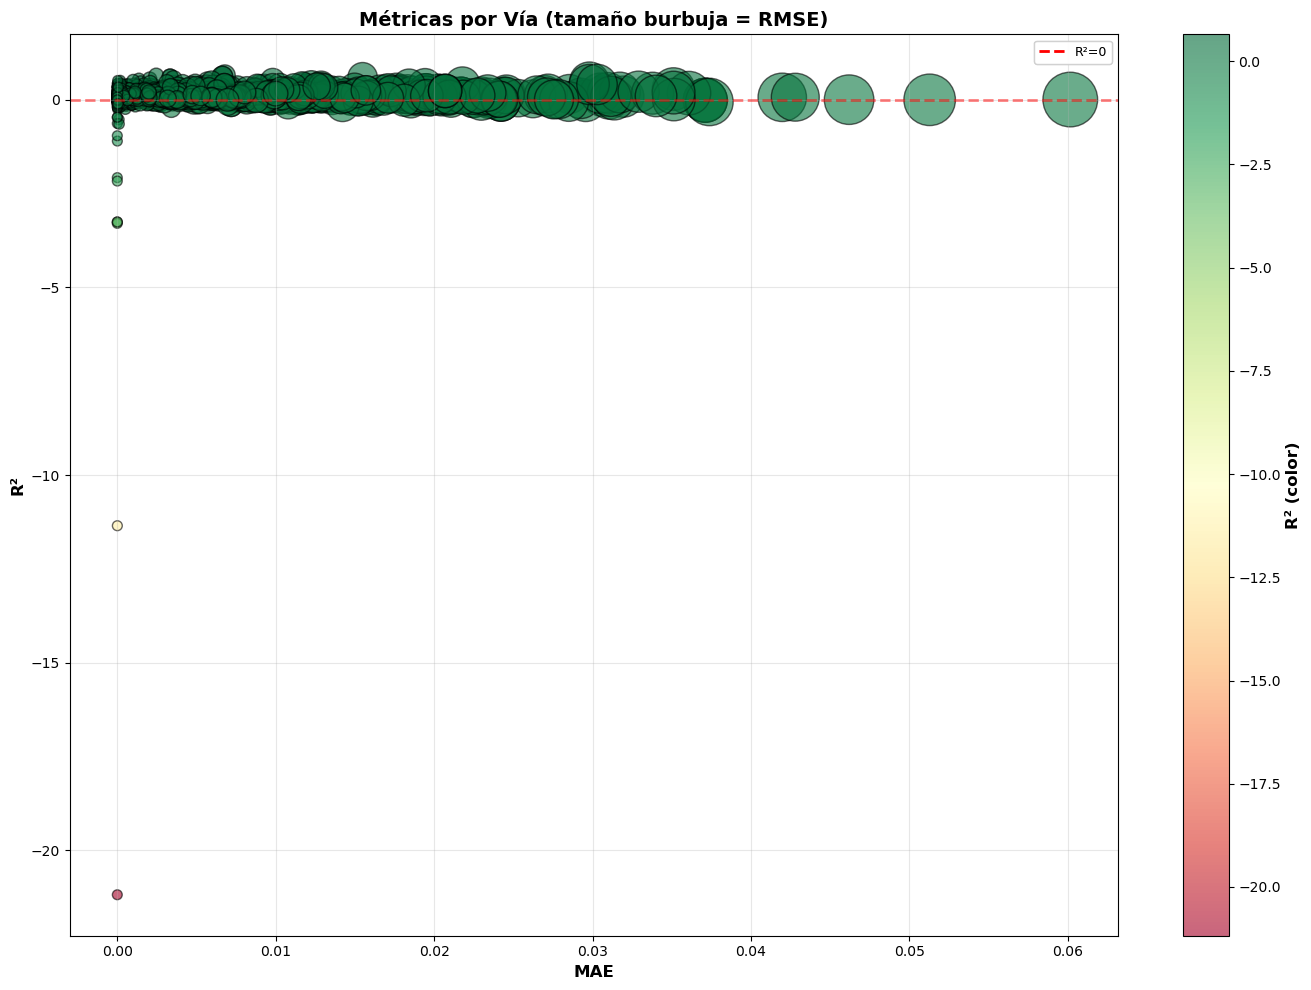

In [14]:
# Preparar datos
vias_nombres = R2_metricas.index.tolist()
r2_mean = R2_metricas['mean'].values
mae_mean = MAE_metricas['mean'].values
rmse_mean = RMSE_metricas['mean'].values

# Crear figura
fig, ax = plt.subplots(figsize=(14, 10))

# Tamaño de burbujas basado en RMSE
# Invertir: RMSE bajo = burbuja pequeña, RMSE alto = burbuja grande
rmse_min = rmse_mean.min()
rmse_max = rmse_mean.max()
sizes = 50 + (rmse_mean - rmse_min) / (rmse_max - rmse_min) * 1500

# Colores según R² (verde=bueno, rojo=malo)
colors = r2_mean

# Scatter plot
scatter = ax.scatter(mae_mean, r2_mean, s=sizes, c=colors, 
                     cmap='RdYlGn', alpha=0.6, edgecolors='black', linewidth=1)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('R² (color)', fontsize=12, fontweight='bold')

# Línea de referencia R²=0
ax.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='R²=0')

# Etiquetas
ax.set_xlabel('MAE', fontsize=12, fontweight='bold')
ax.set_ylabel('R²', fontsize=12, fontweight='bold')
ax.set_title('Métricas por Vía (tamaño burbuja = RMSE)', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend()

# Leyenda de tamaños (RMSE)
sizes_legend = [rmse_min, (rmse_min + rmse_max)/2, rmse_max]
legend_bubbles = []
legend_labels = []

for rmse_val in sizes_legend:
    size = 50 + (rmse_val - rmse_min) / (rmse_max - rmse_min) * 1500
    legend_bubbles.append(plt.scatter([], [], s=size, c='gray', alpha=0.6, edgecolors='black'))
    legend_labels.append(f'RMSE={rmse_val:.2f}')


# Línea R²=0
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='red', linestyle='--', linewidth=2, label='R²=0')]
legend2 = ax.legend(handles=legend_elements, loc='upper right', frameon=True, fontsize=9)
ax.add_artist(legend2)

plt.tight_layout()
plt.savefig(f'{pathway_result}/metricas_bubbles.png', dpi=300)
plt.show()

Total de vías positivas: 947


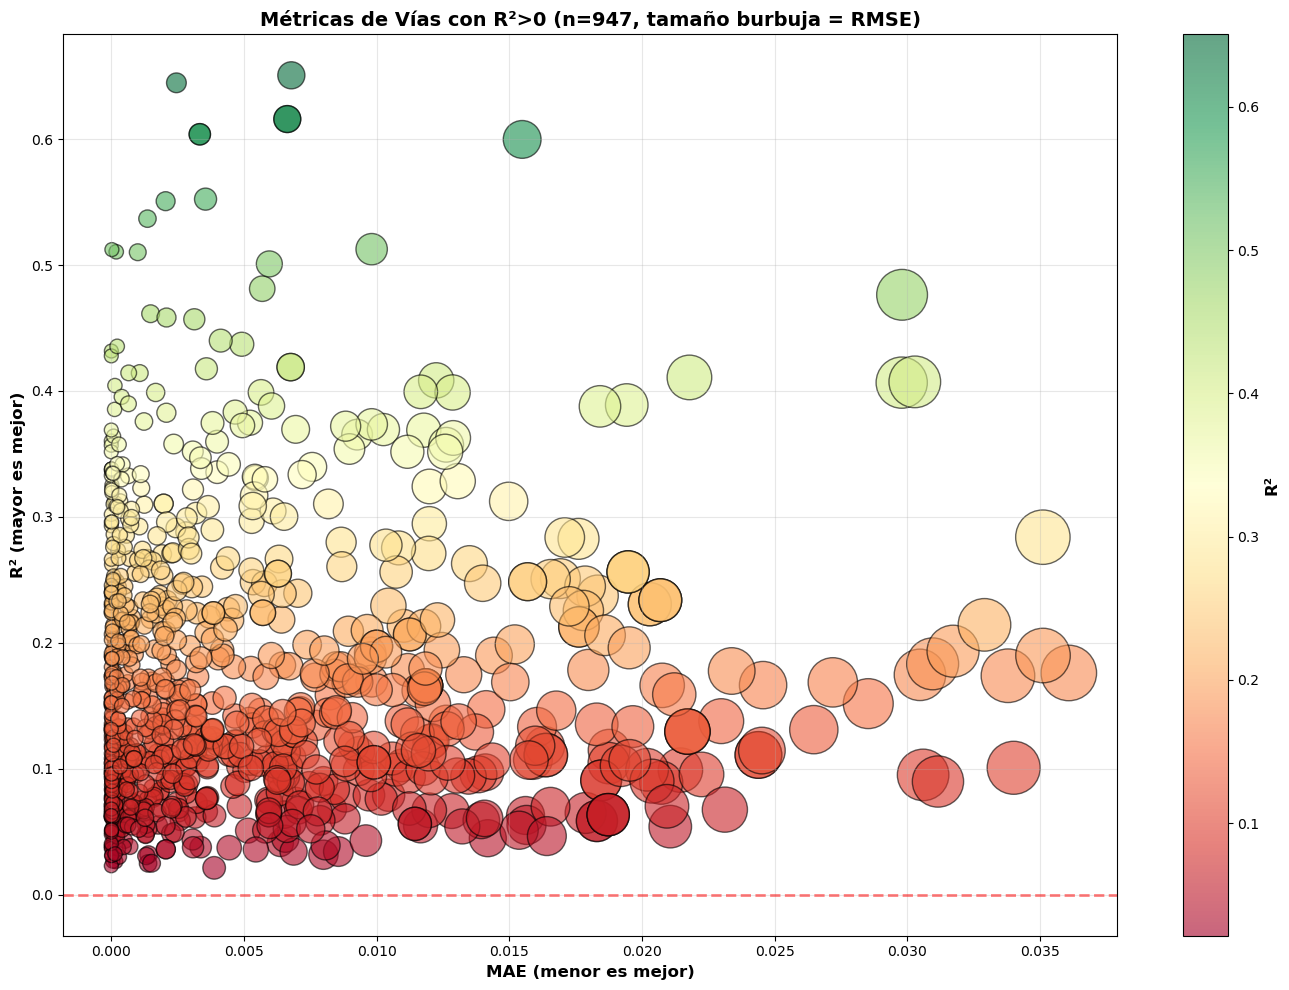

In [15]:
# Filtrar solo vías positivas
vias_nombres_positivas = vias_positivas.index.tolist()
r2_mean_pos = vias_positivas['mean'].values
mae_mean_pos = MAE_metricas.loc[vias_nombres_positivas, 'mean'].values
rmse_mean_pos = RMSE_metricas.loc[vias_nombres_positivas, 'mean'].values

print(f"Total de vías positivas: {len(vias_nombres_positivas)}")

# Crear figura
fig, ax = plt.subplots(figsize=(14, 10))

# Tamaño de burbujas basado en RMSE
rmse_min = rmse_mean_pos.min()
rmse_max = rmse_mean_pos.max()
sizes = 100 + (rmse_mean_pos - rmse_min) / (rmse_max - rmse_min) * 1500

# Colores según R²
colors = r2_mean_pos

# Scatter plot
scatter = ax.scatter(mae_mean_pos, r2_mean_pos, s=sizes, c=colors, 
                     cmap='RdYlGn', alpha=0.6, edgecolors='black', linewidth=1)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('R²', fontsize=12, fontweight='bold')

# Línea R²=0 (referencia)
ax.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='R²=0')

# Etiquetas
ax.set_xlabel('MAE (menor es mejor)', fontsize=12, fontweight='bold')
ax.set_ylabel('R² (mayor es mejor)', fontsize=12, fontweight='bold')
ax.set_title(f'Métricas de Vías con R²>0 (n={len(vias_nombres_positivas)}, tamaño burbuja = RMSE)', 
             fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

# Leyenda de tamaños
sizes_legend = [rmse_min, (rmse_min + rmse_max)/2, rmse_max]
legend_bubbles = []
legend_labels = []

for rmse_val in sizes_legend:
    size = 100 + (rmse_val - rmse_min) / (rmse_max - rmse_min) * 1500
    legend_bubbles.append(plt.scatter([], [], s=size, c='gray', alpha=0.6, edgecolors='black'))
    legend_labels.append(f'RMSE≈{rmse_val:.2f}')


plt.tight_layout()
plt.savefig(f'{pathway_result}/metricas_bubbles_mejores.png', dpi=300)
plt.show()

In [ ]:
MAE_metricas= pd.read_csv("RandomForest/data/Prueba100/resultados_mae.csv", index_col=0).sort_index(axis=0)
R2_metricas= pd.read_csv("RandomForest/data/Prueba100/resultados_r2.csv", index_col=0).sort_index(axis=0)
RMSE_metricas= pd.read_csv("RandomForest/data/Prueba100/resultados_rmse.csv", index_col=0).sort_index(axis=0)

# IMPORTANCIAS

In [16]:
# DataFrame con importancias promediadas por fold
df_importancias = pd.DataFrame()

for fold_data in importancias_todos_folds:
    fold = fold_data['fold']
    importancias = fold_data['importancias']  # shape: (n_estimadores, n_features)
    
    # Promediar entre estimadores
    importancias_promedio = importancias.mean(axis=0)  # shape: (n_features,)
    
    # Agregar como columna
    df_importancias[f'fold_{fold}'] = importancias_promedio

# Agregar índice con nombres de features
df_importancias.index = [f'feature_{i}' for i in range(len(df_importancias))]

# Agregar estadísticas
df_importancias['mean'] = df_importancias.mean(axis=1)
df_importancias['std'] = df_importancias.std(axis=1)

df_importancias.to_csv(f'{pathway_result}/importancias_promedio_por_fold.csv')
print(df_importancias)


                fold_1    fold_2    fold_3    fold_4    fold_5      mean  \
feature_0     0.000192  0.000088  0.000057  0.000037  0.000187  0.000112   
feature_1     0.000089  0.000132  0.000000  0.000052  0.000096  0.000074   
feature_2     0.000182  0.000204  0.000098  0.000029  0.000229  0.000148   
feature_3     0.000264  0.000352  0.000309  0.000075  0.000346  0.000269   
feature_4     0.000177  0.000169  0.000126  0.000052  0.000106  0.000126   
...                ...       ...       ...       ...       ...       ...   
feature_3281  0.000149  0.000209  0.000132  0.000146  0.000294  0.000186   
feature_3282  0.000561  0.000460  0.000299  0.000470  0.000287  0.000415   
feature_3283  0.000201  0.000149  0.000251  0.000170  0.000186  0.000191   
feature_3284  0.000008  0.000000  0.000203  0.000201  0.000048  0.000092   
feature_3285  0.000095  0.000199  0.000181  0.000040  0.000218  0.000147   

                   std  
feature_0     0.000065  
feature_1     0.000045  
feature_2   

In [17]:
# Top 20 features más importantes (promedio entre folds)
print("\nTop 20 Features Más Importantes:")
top_20 = df_importancias.nlargest(20, 'mean')[['mean', 'std']]
print(top_20)

# Features más estables (menor variabilidad entre folds)
print("\nTop 20 Features Más Estables:")
estables = df_importancias.nsmallest(20, 'std')[['mean', 'std']]
print(estables[estables['mean'] > 0.05])  

# Features con mayor variabilidad
print("\nTop 20 Features Más Variables:")
variables = df_importancias.nlargest(20, 'std')[['mean', 'std']]
print(variables)

# Resumen estadístico
print("\nEstadísticas de Importancias:")
print(df_importancias['mean'].describe())


Top 20 Features Más Importantes:
                  mean       std
feature_69    0.070301  0.014676
feature_1234  0.017044  0.006498
feature_747   0.011523  0.007665
feature_2737  0.007976  0.004670
feature_827   0.007863  0.005066
feature_1857  0.005577  0.003496
feature_442   0.005013  0.003107
feature_3235  0.004085  0.001277
feature_546   0.004044  0.001000
feature_2341  0.003983  0.001598
feature_2810  0.003852  0.002903
feature_2142  0.003839  0.001744
feature_2831  0.003592  0.002101
feature_596   0.003450  0.001455
feature_1579  0.003265  0.001385
feature_3005  0.003060  0.001823
feature_2388  0.002990  0.000961
feature_2164  0.002832  0.001763
feature_2163  0.002779  0.003981
feature_1537  0.002497  0.001458

Top 20 Features Más Estables:
Empty DataFrame
Columns: [mean, std]
Index: []

Top 20 Features Más Variables:
                  mean       std
feature_69    0.070301  0.014676
feature_747   0.011523  0.007665
feature_1234  0.017044  0.006498
feature_827   0.007863  0.00506

# ANÁLISIS IMPORTANCIAS DE N_ESTIAMTORS = 100
## Top 20 Features Más Importantes:
                  mean       std
feature_69    0.051363  0.011261
feature_1234  0.013414  0.004081
feature_747   0.009629  0.006359
feature_827   0.006173  0.003313
feature_2737  0.005560  0.003764
feature_1857  0.005019  0.004055
feature_3235  0.003529  0.001285
feature_442   0.003449  0.001755
feature_2341  0.003364  0.000927
feature_546   0.003056  0.001099
feature_2831  0.003041  0.001694
feature_2810  0.003039  0.002496
feature_1579  0.002812  0.001309
feature_3005  0.002792  0.001509
feature_2142  0.002726  0.001286
feature_2388  0.002661  0.001332
feature_596   0.002558  0.000993
feature_2164  0.002305  0.001354
feature_2163  0.002089  0.002854
feature_1962  0.001988  0.001084

## Top 20 Features Más Estables:
Empty DataFrame
Columns: [mean, std]
Index: []

## Top 20 Features Más Variables:
                  mean       std
feature_69    0.051363  0.011261
feature_747   0.009629  0.006359
feature_1234  0.013414  0.004081
feature_1857  0.005019  0.004055
feature_2737  0.005560  0.003764
feature_827   0.006173  0.003313
feature_2163  0.002089  0.002854
feature_1243  0.001799  0.002722
feature_2810  0.003039  0.002496
feature_901   0.001799  0.002004
feature_1752  0.001772  0.001870
feature_14    0.001656  0.001865
feature_442   0.003449  0.001755
feature_2831  0.003041  0.001694
feature_3239  0.001441  0.001657
feature_3005  0.002792  0.001509
feature_2164  0.002305  0.001354
feature_2114  0.001756  0.001338
feature_2388  0.002661  0.001332
feature_1579  0.002812  0.001309

## Estadísticas de Importancias:
count    3286.000000
mean        0.000304
std         0.000983
min         0.000000
25%         0.000152
50%         0.000231
75%         0.000340
max         0.051363
Name: mean, dtype: float64
